### Простейшая модель гликолиза

Простейшая модель гликолиза описывается уравнениями следующего вида:

$ y_1' = 1 - y_1 y_2, $ \
$ y_2' = \alpha y_2 (y_1 - \frac{1 + \beta}{y_2 + \beta}) $

предложенными Дж. Хиггинсом. \
В системе β = 10, α = 100, 200, 400, 1000.\
Начальные условия для системы: $ y_1(0) = 1, y_2(0) = 0,001, T_k = 50 $. \
Решение этой системы — релаксационные автоколебания (жесткий предельный цикл).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

### Реализация решения нелинейных уравнений методом Ньютона

In [71]:
def diff_v5(func, h, x, xid=0):
  h_vec = np.zeros(len(x))
  h_vec[xid] = h
  return 3 * (func(x + h_vec) - func(x - h_vec)) / (2 * 2 * h) - 3 * (func(x + 2 * h_vec) - func(x - 2 * h_vec)) / (5 * 4 * h) + 1 * (func(x + 3 * h_vec) - func(x - 3 * h_vec)) / (10 * 6 * h)

def calc_jacobian(F, x):
  h = 10**-5
  N = len(x)
  res = np.zeros([N, N])
  for fid in range(0, N):
    for xid in range(0, N):
      func = lambda x: F(x)[fid]
      res[fid, xid] = diff_v5(func, h, x, xid)

  return res

def solve(func, x0, eps=10**-4):
  sol = x0
  iter_counter = 0
  J = calc_jacobian(func, sol)
  J = np.linalg.inv(J)
  while(iter_counter < 10):
    F = np.matrix(func(sol))

    sol = np.array((np.matrix(sol).T - J * F.T).T)[0]
    iter_counter += 1
  return sol

### Реализация методов РК и Эйлера

In [76]:
class RungeKutta:
  def __init__(self, matr, t0, Y0, F):
    # коэффициенты из матрицы метода
    self.S = len(matr) - 1
    self.C = matr[:self.S, 0].T.tolist()[0]
    self.B = matr[self.S, 1:].tolist()[0]
    self.A = matr[:self.S, 1:]
    self.explicit = RungeKutta.isExplicit(matr)
    # текущее решение (равно начальному)
    self.Y = Y0
    self.DY = F(t0, Y0)
    # текущее время
    self.t = t0
    # правая часть системы
    self.F = F
    # сохраненный след
    self.y_trace = []
    self.dy_trace = []
    for i in range(0, len(self.Y)): 
      self.y_trace.append([]) 
      self.dy_trace.append([])
    self.t_trace = []

    self.SaveTrace()

  def isExplicit(matr):
    N = len(matr)
    for l in range(0, N):
      for c in range(l + 1, N):
        if matr[l, c] != 0:
          return False
    return True


  def NextStep(self, dt, explicit=None):
    if dt < 0:
      return;
    tmp_exl = self.explicit
    if explicit is True or explicit is False:
      tmp_exl = explicit

    if tmp_exl:
      self.ExplicitNextStep(dt)
    else:
      self.ImplicitNextStep(dt)

    self.t += dt
    self.DY = self.F(self.t, self.Y)
    self.SaveTrace()


  # решение явным методом
  def ExplicitNextStep(self, dt):
    if dt < 0:
      return;
    N = len(self.Y)
    # получаем значения K на каждой стадии
    K = [None] * self.S
    YN = self.Y
    for s in range(0, self.S):
      t_s = self.C[s] * dt
      YY = [None] * N
      YY = YN
      for j in range(0, s):
        YY += self.A[s, j] * dt * np.copy(K[j])
      K[s] = self.F(t_s, YY)
    
    # высчитываем y_{n+1}
    for s in range(0, self.S):
      self.Y += dt * self.B[s] * np.copy(K[s]) 


  # решение неявным методом
  def ImplicitNextStep(self, dt):
    if dt < 0:
      return;
    
    Equation = lambda y_np1: y_np1 - dt * np.copy(self.F(self.t, y_np1)) - np.copy(self.Y)
    self.Y = solve(Equation, x0=np.copy(self.Y))


  def start(self, step, t_end, explicit=None):
      arr = np.arange(self.t, t_end + step, step)
      n = len(arr)

      for i in range(1, n):
        self.NextStep(step, explicit=explicit)


  def SaveTrace(self):
    for i in range(0, len(self.Y)):
      (self.y_trace[i]).append(self.Y[i])

    for i in range(0, len(self.Y)):
      (self.dy_trace[i]).append(self.DY[i])

    self.t_trace.append(self.t)


### Реализация метода Розенброка

In [ ]:

class RosenBrok():
    def __init__(self, f, t, x, h):
        self.x = x
        self.f = f
        self.t = t
        self.h = h

    def partialDerivative (self, j):

        H = np.zeros_like(x)
        H[j] = self.h
        return 3 * (self.f(self.t, self.x + H) - self.f(self.t, self.x - H)) / (4 * self.h) \
            - 3 * (self.f(self.t, self.x + 2*H) - self.f(self.t, self.x - 2*H)) / (20 * self.h) \
                + (self.f(self.t, self.x + 3*H) - self.f(self.t, self.x - 3*H)) / (60 * self.h)

    def JacobyMatrix(self, F, t, x):

        m = len(F)
        n = len(x)
        J = np.empty(shape=(m, n))
        for i in range(m):
            for j in range(n):
                J[i, j] = self.partialDerivative(self.f[i],t, self.x, self.h, j)

        return J

    def crosRosenBrokMethod(self, F, x_0, t_1, t_2, N):

        t = np.linspace(t_1, t_2, num = N + 1, endpoint = True)
        dt = (t_2 - t_1) / N

        dim = len(x_0)
        x = np.empty(shape=(N + 1, dim))
        x[0] = x_0

        for n in range(N):
            J = self.JacobyMatrix(F, t[n], x[n], dt)
            M = np.eye(dim) - (0.5 + 0.5 * 1j) * dt * J
            f = np.empty(dim)
            for i in range(dim):
                f[i] = F[i](t[n] + dt * 0.5, x[n])

            w = np.linalg.solve(M, f)
            x[n + 1] = x[n] + dt * w.real

        return t, x

In [77]:
def plot_3d(x_, y_, z_, labels=['X', 'Y', 'Z']):
  fig = plt.figure(figsize=[18, 10])
  ax = fig.add_subplot(projection='3d')

  ax.plot(x_, y_, z_, label='solution')
  ax.set_xlabel(labels[0], fontsize=15)
  ax.set_ylabel(labels[1], fontsize=15)
  ax.set_zlabel(labels[2], fontsize=15)
  plt.draw()
  plt.show()

### Данные из условия задачи

In [78]:
beta = 10
alfa = [100, 200, 400, 1000]
Y0 = [1, 1.001]
T_end = 50

def dy1(y1, y2, alfa, beta):
  return 1 - y1 * y2
def dy2(y1, y2, alfa, beta):
  return alfa * y2 * (y1 - (1 + beta)/(y2 + beta))

def F(t, u, alfa, beta):
  y1 = dy1(u[0], u[1], alfa, beta)
  y2 = dy2(u[0], u[1], alfa, beta)
  return [y1, y2]

def F0(t, u):
  return F(t, u, alfa[0], beta)
def F1(t, u):
  return F(t, u, alfa[1], beta)
def F2(t, u):
  return F(t, u, alfa[2], beta)
def F3(t, u):
  return F(t, u, alfa[3], beta)

### Результат при $ \alpha = 100 $

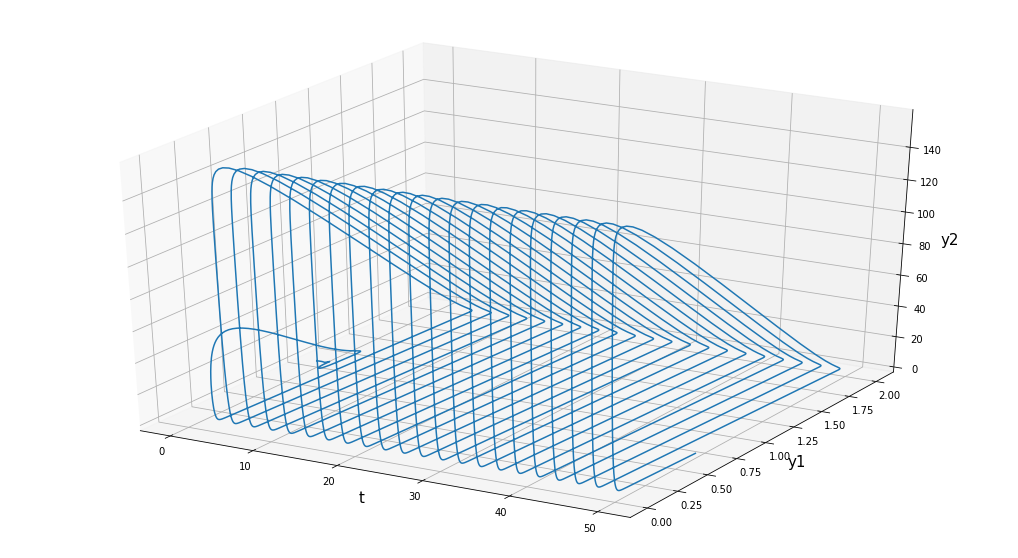

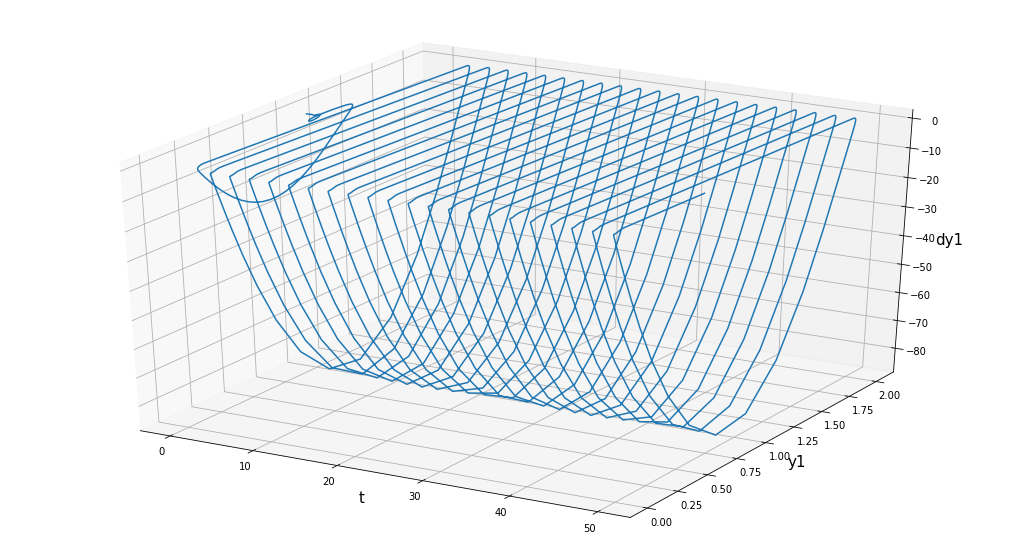

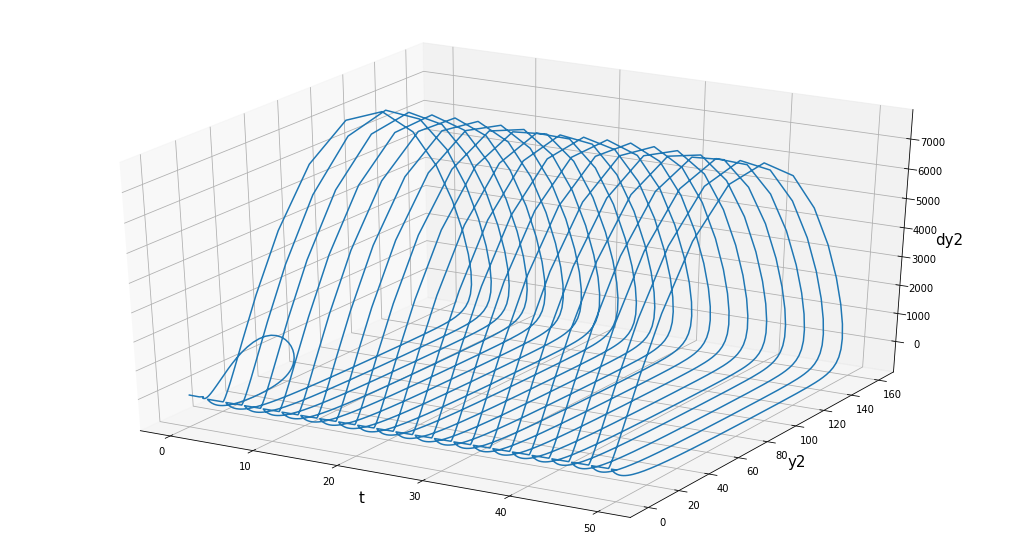

In [79]:
rk3 = RungeKutta(np.zeros([2, 2]), 0, Y0, F0)
rk3.start(0.003, T_end, explicit=False)
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.y_trace[1], labels=['t', 'y1', 'y2'])

plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.dy_trace[0], labels=['t', 'y1', 'dy1'])
plot_3d(rk3.t_trace, rk3.y_trace[1], rk3.dy_trace[1], labels=['t', 'y2', 'dy2'])

### Результат при $ \alpha = 200 $

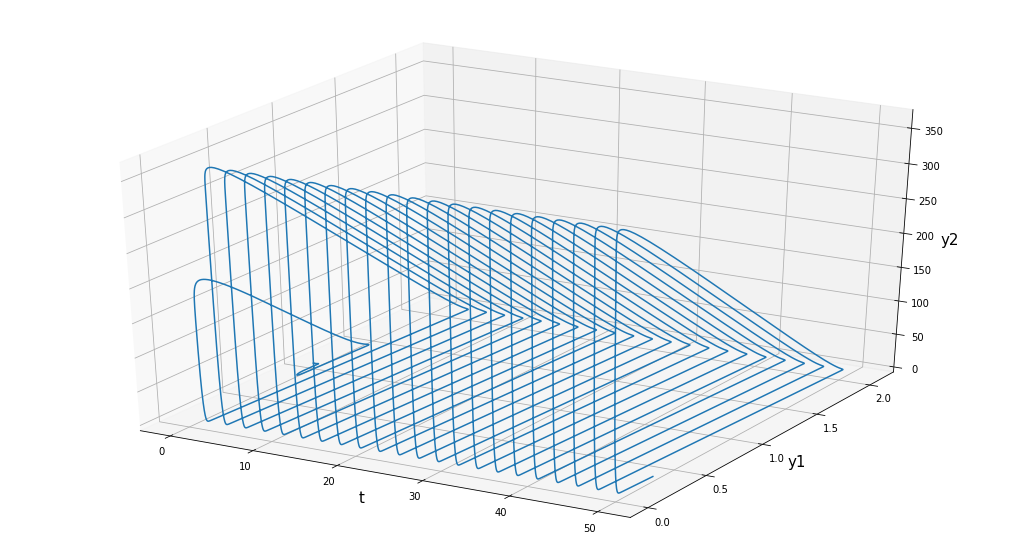

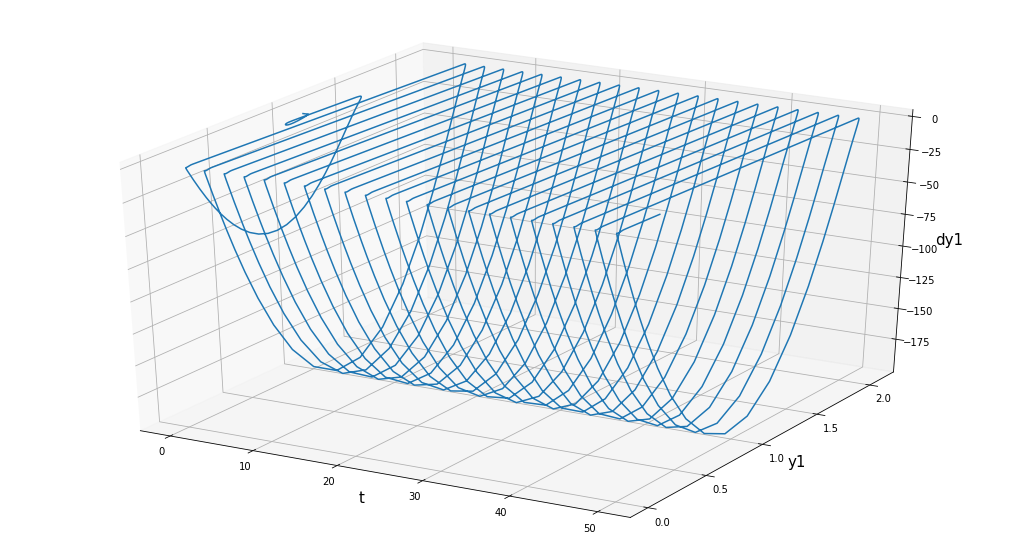

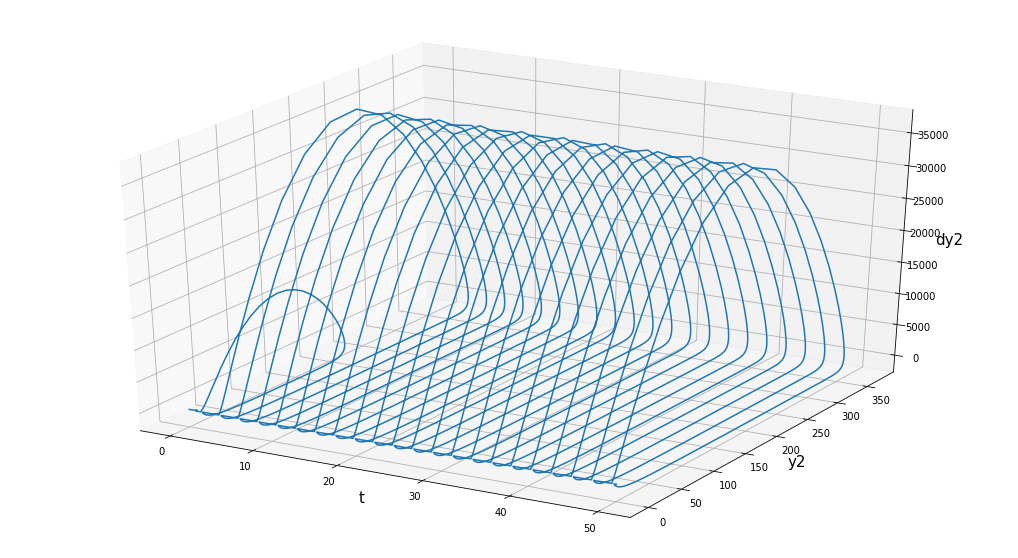

In [66]:
rk3 = RungeKutta(np.zeros([2, 2]), 0, Y0, F1)
rk3.start(0.001, T_end, explicit=False)
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.y_trace[1], labels=['t', 'y1', 'y2'])

plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.dy_trace[0], labels=['t', 'y1', 'dy1'])
plot_3d(rk3.t_trace, rk3.y_trace[1], rk3.dy_trace[1], labels=['t', 'y2', 'dy2'])

### Результат при $ \alpha = 400 $

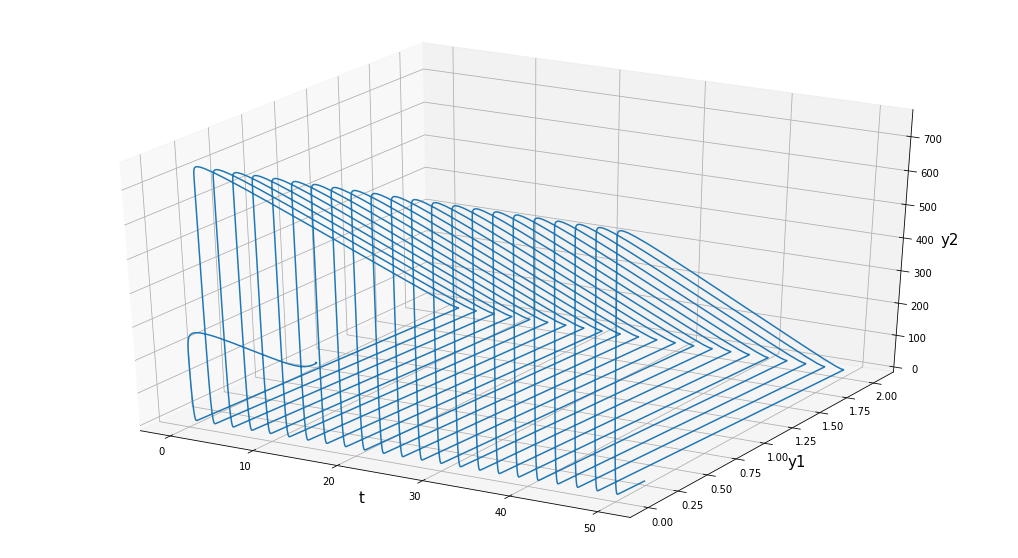

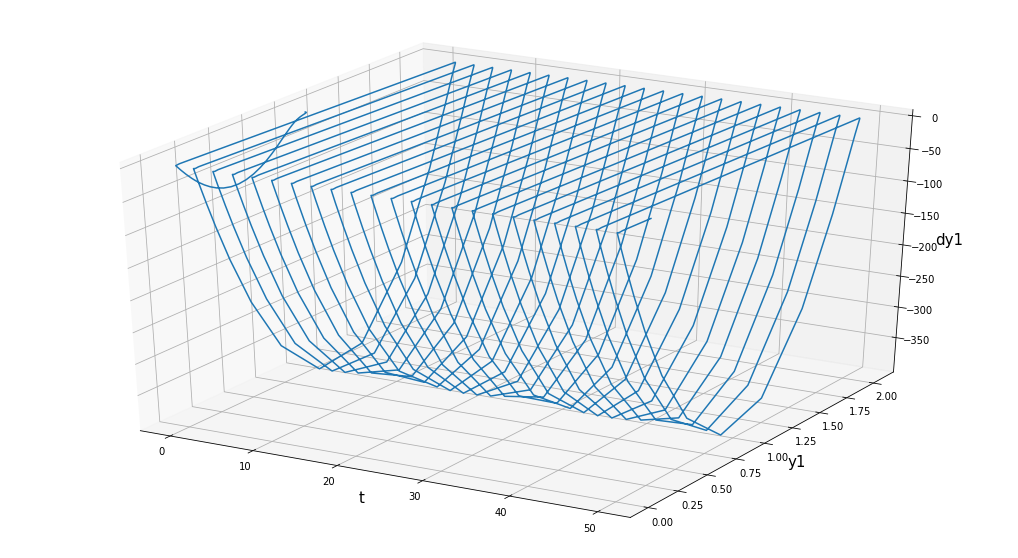

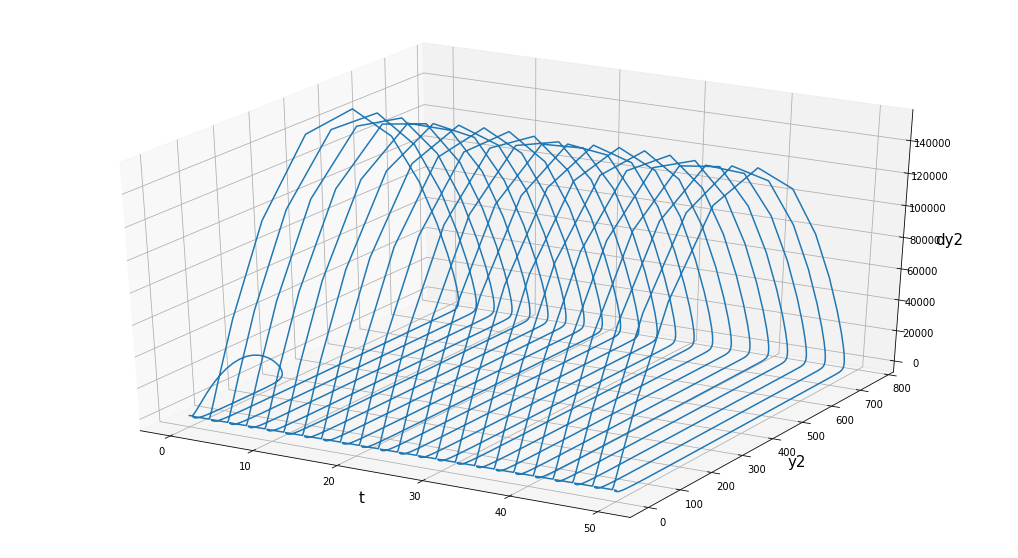

In [67]:
rk3 = RungeKutta(np.zeros([2, 2]), 0, Y0, F2)
rk3.start(0.0008, T_end, explicit=False)
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.y_trace[1], labels=['t', 'y1', 'y2'])

plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.dy_trace[0], labels=['t', 'y1', 'dy1'])
plot_3d(rk3.t_trace, rk3.y_trace[1], rk3.dy_trace[1], labels=['t', 'y2', 'dy2'])

### Результат при $ \alpha = 1000 $

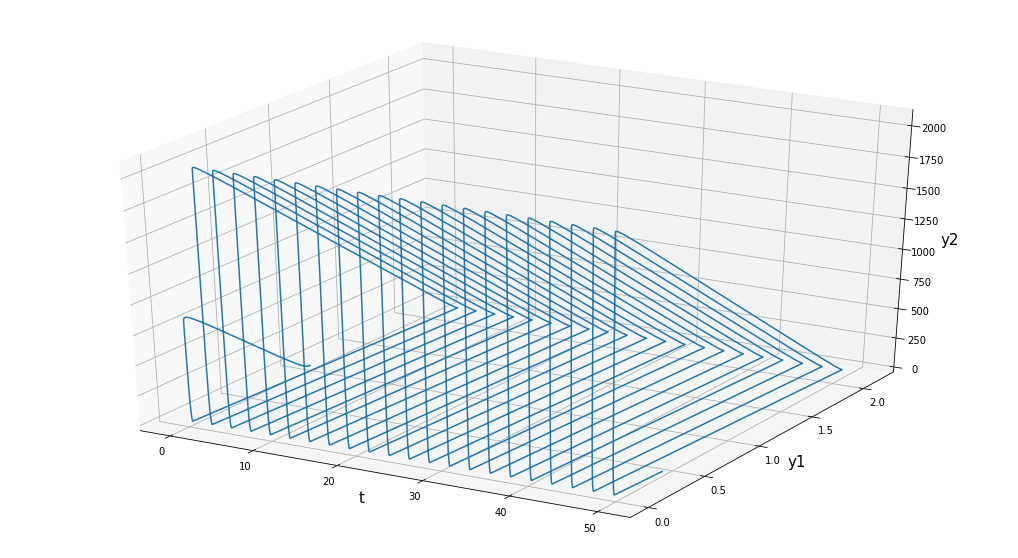

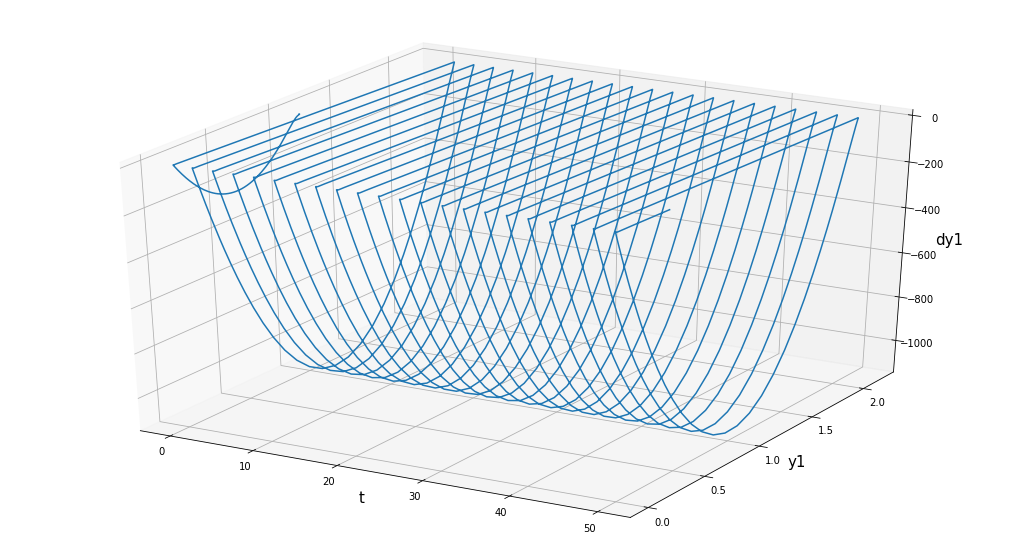

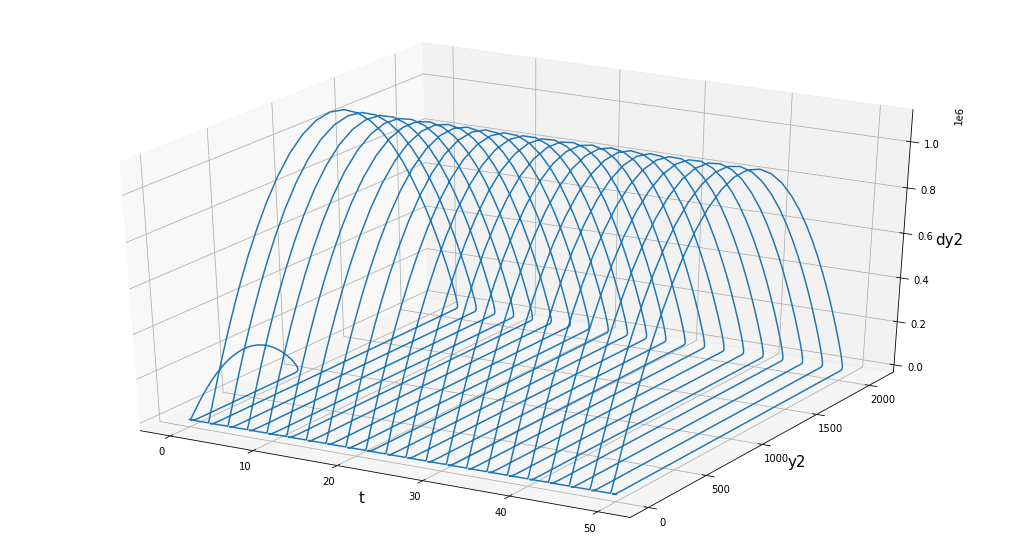

In [65]:
rk3 = RungeKutta(np.zeros([2, 2]), 0, Y0, F3)
# с шагом меньше уже все плохо
rk3.start(0.0001, T_end, explicit=False)
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.y_trace[1], labels=['t', 'y1', 'y2'])

plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.dy_trace[0], labels=['t', 'y1', 'dy1'])
plot_3d(rk3.t_trace, rk3.y_trace[1], rk3.dy_trace[1], labels=['t', 'y2', 'dy2'])

### Сравнение с результатом при явном методе третьего порядка ($\alpha = 100$)

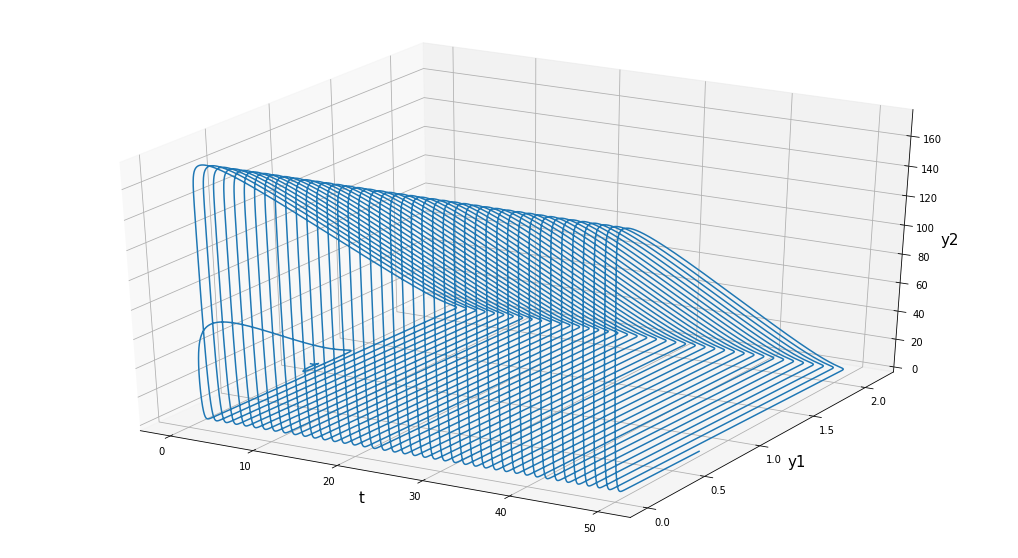

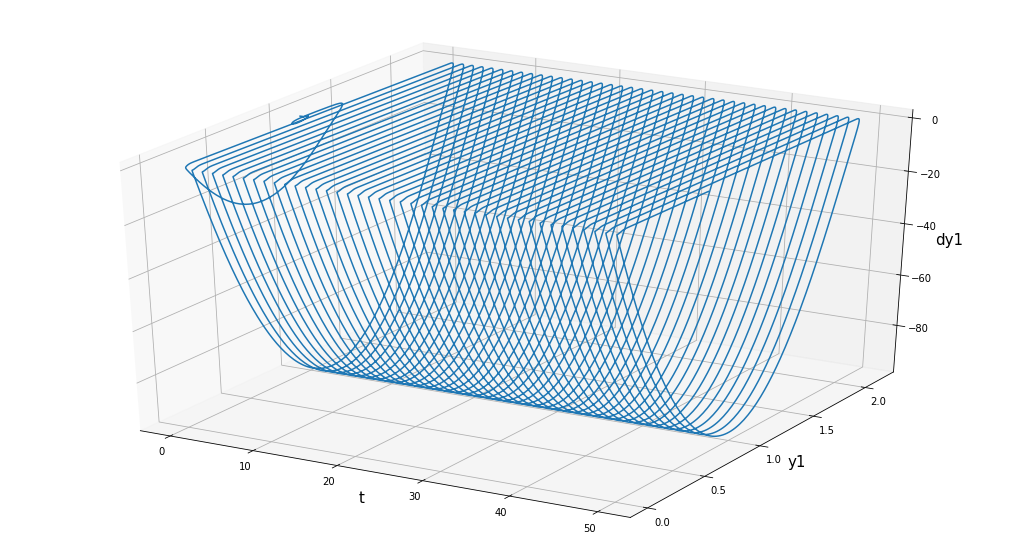

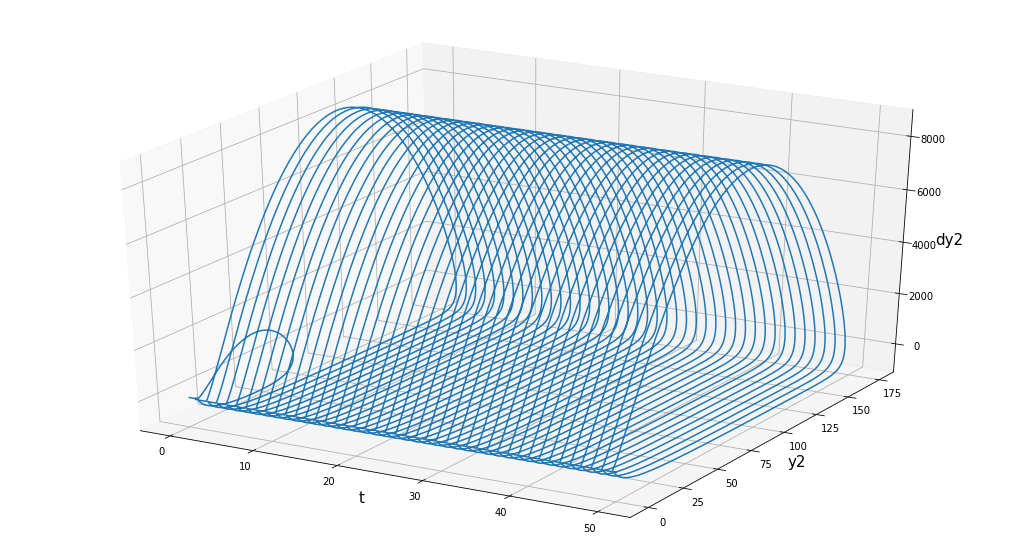

In [ ]:
rkm = np.matrix([
    [  0,   0,   0,   0],
    [1/3, 1/3,   0,   0],
    [2/3,   0, 2/3,   0],
    [  0, 1/4,   0, 3/4]
])

rk3 = RungeKutta(rkm, 0, Y0, F0)
rk3.start(0.00001, T_end)
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.y_trace[1], labels=['t', 'y1', 'y2'])
plot_3d(rk3.t_trace, rk3.y_trace[0], rk3.dy_trace[0], labels=['t', 'y1', 'dy1'])
plot_3d(rk3.t_trace, rk3.y_trace[1], rk3.dy_trace[1], labels=['t', 'y2', 'dy2'])